---
title: Classifying Podium Finishers with Decision Trees
---
This section is probably the most substantial and important to the questions asked under this project. We will be attempting to finally make predictions for horse racing, measure how accurate we are, and create the early workings of a more advanced betting system.

For this analysis, we will be attempting to maximize the precision of our classifiers in predicting correct horse racing podium finishers. The preference for maximizing precision over other model evaluation metrics stems from the focus on accurately predicting the horse podium finishers. Precision provides insight into the percentage of correctly predicted podium finishers among all the instances predicted as such. In the context of betting, where correctness is financially impactful, accuracy and negative predictive value become less relevant, as they assess the model's performance on predicting horses that do not finish on the podium. Sensitivity (recall) is insightful as it quantifies the proportion of correctly predicted podium finishers out of the total pool, highlighting potential betting opportunities. However, for this analysis, the emphasis is placed on the accuracy of predictions rather than maximizing betting opportunities. Hence, precision serves as the primary metric of interest for evaluating all models.

This section is done with Python.

# Methods
In this section, we will explore a variety of decision tree methods for classification, including a **Decision Tree Classifier**, **Random Forests**, **AdaBoost Models**, and **Gradient Boosting**, specifically XGBoost.

A Decision Tree Classifier is a machine learning algorithm that recursively partitions the input space into regions, assigning a class label to each region. It begins with the entire dataset at the root node and selects the best feature and threshold to split the data into subsets, optimizing for homogeneity within each subset. This process is repeated at each node, creating a tree structure, until a stopping criterion is met. The resulting leaf nodes represent class labels, and predictions for new instances are made by traversing the tree from the root to an appropriate leaf, following the decision rules based on the feature values. Decision Trees are interpretable and versatile, making them valuable for both classification and regression tasks, though they can be prone to overfitting, which can be addressed through techniques like pruning and ensemble methods.

A Random Forest is an ensemble learning method that builds multiple decision trees during training and outputs the mode of the classes for classification tasks or the average prediction for regression tasks. The "random" in Random Forest comes from introducing randomness both in the data and the features used to construct each individual tree. During training, each tree is built using a bootstrap sample (randomly sampled with replacement) from the original dataset, and at each node of the tree, a random subset of features is considered for the split. This randomness introduces diversity among the trees, preventing overfitting and enhancing the model's robustness. The final prediction is then determined by aggregating the predictions of all the trees. Random Forests are known for their high accuracy, scalability, and ability to handle complex, high-dimensional datasets, making them a popular choice in various machine learning applications.

AdaBoost, short for Adaptive Boosting, is an ensemble learning technique designed to improve the performance of weak classifiers and create a strong, accurate classifier. It operates by iteratively training a series of weak classifiers on different weighted versions of the training data, where weights are adjusted to focus on instances that the current classifier misclassifies. In each iteration, the algorithm assigns higher weights to misclassified instances, and the subsequent weak classifier is forced to prioritize the correct classification of these instances. The final prediction is made by combining the individual predictions of all weak classifiers through weighted majority voting. AdaBoost is particularly effective in handling imbalanced datasets and tends to generalize well, producing a robust model that performs well on diverse datasets and various types of weak classifiers.

[XGBoost](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/), or Extreme Gradient Boosting, is a powerful and efficient gradient boosting framework that has gained popularity for its high performance in a variety of machine learning tasks. XGBoost enhances traditional gradient boosting by employing a regularization term in the objective function, which helps prevent overfitting. It is designed for both classification and regression problems and is known for its speed, scalability, and flexibility. XGBoost sequentially builds a series of decision trees, and at each iteration, it minimizes a combined objective function that includes both a loss function and a regularization term. The algorithm also incorporates features like tree pruning and parallel computing, making it computationally efficient. Additionally, XGBoost supports custom loss functions and provides tools for feature importance analysis, making it a versatile and widely used tool in machine learning competitions and real-world applications.


# Data Preparation
In order to ensure we are accounting for differences in horse races in our performance dataset (i.e., race distance, going, track, course, etc.), we are going to be creating decision trees only for particular races. I do not want to create any sort of predicition model that tries to aggregate all races together for all distances, goings, tracks, etc.. While we may have found in our EDA section that variables such track going might not have THAT large of an effect on races of equivalent distances, I still want to air on the side of caution by only making decision trees for races of the same distance and exact same condition. It is through this strategy that we can more closely identify how our more significant variables like draw, average placement, days of rest, etc. drive how a horse will finish will a race. Because prediction is now at the center of our focus in this section, we want to make sure our race variables are as well-trimmed as they possibly can be.

I am going to start by looking at the race distance that is most common in our dataset.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Reading in our data
perf = pd.read_csv('../../../data/01-modified-data/perf.clean.no.error.csv')

/tmp/ipykernel_135789/1857860733.py:2: DtypeWarning: Columns (10,18,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  perf = pd.read_csv('../../../data/01-modified-data/perf.clean.no.error.csv')


In [3]:
# Finding most common distance
perf['distance'].value_counts()

1200    54307
1400    50633
1650    40298
1600    30907
1800    26647
1000    20216
2000     7586
1235     6067
2200     4020
1030     3445
975      2645
1575     2464
1150     2400
2230     1328
2400     1231
1900      957
1050      835
2050      281
2450      267
1100      208
2250      202
2100      144
1170       35
1799       12
2300        4
Name: distance, dtype: int64

We can see here that our distance of 1200m is the most common distance. We can also confirm with research about the HKJC that the 1200m race is indeed still one of the most popular track races being run today.

Let's go ahead and subset our data to only include races that are 1200m.

In [4]:
perf_clean = perf[perf['distance'] == 1200]

Now we will go ahead and check what the most common track type is at the 1200m track distance and subset based on this track type.

In [5]:
perf_clean['track'].value_counts()

Turf     41065
AWT       7829
Grass     5413
Name: track, dtype: int64

In [6]:
perf_clean = perf_clean[perf_clean['track'] == 'Turf']

Now let's look at the most common course and subset based on said course.

In [7]:
perf_clean['course'].value_counts()

A         12424
C          7805
B          7313
C+3        4855
B+2        3716
A+3        2444
A(N)        716
B(N)        584
D           583
A+2         438
B+2(N)      139
A+2(N)       37
B+3          11
Name: course, dtype: int64

In [8]:
perf_clean = perf_clean[perf_clean['course'] == 'A']

Once again, we will subset the data, this time based on the class of the race (race class determines what range of horse ratings will be competing in the race).

In [9]:
perf_clean['race_class'].value_counts()

4       4219
3       3923
5       1485
2       1340
1        385
1&2      279
HKG1     165
HKG3     148
6        116
G1        99
P         64
4S        62
HKG2      58
3S        23
G2        23
G3        18
R          7
4R         6
23YO       4
Name: race_class, dtype: int64

In [10]:
perf_clean = perf_clean[perf_clean['race_class'] == '4']

Just a couple more subsets to go! Lets go ahead and look at race going, the condition in which the race track was at the time of the race.

In [11]:
perf_clean['going'].value_counts()

G     2245
GF    1457
GY     351
Y       86
YS      35
F       32
S       13
Name: going, dtype: int64

In [12]:
perf_clean = perf_clean[perf_clean['going'] == 'G']

And last but not least, we will go ahead and subset based on if the race took place at Happy Valley or Sha Tin.

In [13]:
perf_clean['race_location'].value_counts()

HV    1334
ST     911
Name: race_location, dtype: int64

In [14]:
perf_clean = perf_clean[perf_clean['race_location'] == 'HV']

And finally, we have a dataset in which we will create some decision trees. You will see, we went all the way from 250k + observations, all the way to about 1300. Again, this "cut" might seem stark at first, but we are just looking at ONE possible race scenario. If we were to make a comprehensive, closer to "perfect" race predicition model, we would be making a decision tree for every possible cut of data (every possible race scenario). Obviously, creating decision trees, tuning hyperparameters, etc. for every possible race scenario would get computationally expensive. For the sake of this project, again, we are just looking at the race scenario that has happened the most at the HJKC.

Now that we have our data for one possible race scenario, we will go ahead and create our target variable, 'podium'.

In [15]:
perf_clean['podium'] = np.nan
perf_clean['podium'] = np.where(perf_clean['final_placing'].isin([1, 2, 3]), 1, 0)

In [16]:
# Dropping rows where our feature set has NA values
perf_clean_na = perf_clean.dropna(subset=['rating','on_date_weight','draw','average_placement','days_between'])

FINALLY, we will subset our data to include only our variables of interest. If you remember, we found an optimal numerical feature set in the PCA section. We will stick with this feature set for our decision tree analysis.

In [17]:
# Creating feature set and target variable
X = perf_clean_na[['rating','on_date_weight','draw','average_placement','days_between']]
y = perf_clean_na['podium']

In [18]:
# Creating a training, validation, and test set
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=100)

Our data is now fully prepared for our decision tree making process.

# An Overview of the Distribution of 'podium'
Before we fully delve into making decision trees, let's first take a look at the distribution of our target variable, 'podium'.

In [19]:
y.value_counts()

0    976
1    335
Name: podium, dtype: int64

We can see that roughly a third of our data falls under the category of having a podium finish. Conceptually, this makes perfect sense since for all races, there will only be 3 podium finishers per race. What this means for any decision tree we make is that it will the decision tree might become biased towards the majority class, NOT podium finishing. Any imbalanced class distribution may lead to biased impurity measures, favoring the majority class, leading to overfitting and poor generalization.

While this imbalance raises some concerns, we can mitigate this bias through techniques like class weighting (e.g., adaboost) which penalizes misclassifcations of the minority class more heavily or through ensenmble methods like using Random Forests, which build multiple descions trees and combine predicitions. We will explore such methods in the following sections.

# Making a Random Classifier
We will first make a random classifier to serve as the "baseline" model for comparsion with any decision trees we make.

In [20]:
import random
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [21]:
def random_classifier(y_data):
    ypred=[];
    max_label=np.max(y_data)
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))

    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("precision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))

In [22]:
random_classifier(y)

-----RANDOM CLASSIFIER-----
count of prediction: dict_values([673, 638])
probability of prediction: [0.51334859 0.48665141]
accuracy 0.5110602593440122
precision, recall, fscore, (array([0.74888559, 0.26018809]), array([0.51639344, 0.49552239]), array([0.61127956, 0.34121274]), array([976, 335]))


We can see that with our random classifier, we have about a 50/50 shot at correctly predicting a podium finish for a horse. We want to beat this 50/50 shot at predicting whether a horse has a podium finish or not.

# Decision Tree
Now we will go ahead and fit a decision tree based on the Gini index.

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt

We are going to define a function that is able to output scores for accuracy, recall, and precision, and F-1 score and also give us a confusion matrix.

In [24]:
def confusion_plot(y_data,y_pred):
    cm = confusion_matrix(y_data,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    Accuracy = metrics.accuracy_score(y_data, y_pred)
    Precision = metrics.precision_score(y_data, y_pred)
    Sensitivity = metrics.recall_score(y_data, y_pred)
    Specificity = metrics.recall_score(y_data, y_pred,pos_label=0)
    NPV = metrics.precision_score(y_data, y_pred,pos_label=0)
    F1 = metrics.f1_score(y_data, y_pred)

    print("Accuracy:",Accuracy)
    print("Specificity:",Specificity)
    print("Precision:", Precision)
    print("Sensitivity",Sensitivity)
    print("Negative Predictive Value:",NPV)
    print("F1-score:", F1 )

Now we will go ahead and fit a decision tree, looking at its performance on the test data before hyperparameter tuning.

------TRAINING------


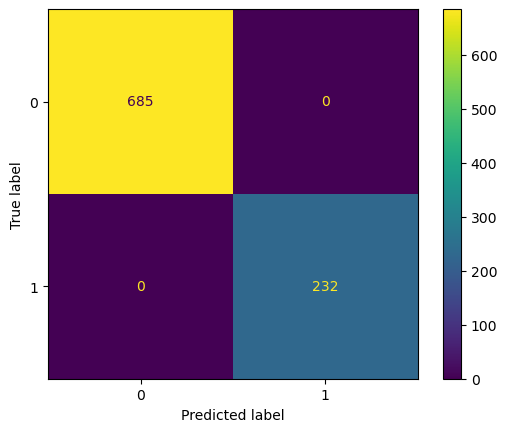

Accuracy: 1.0
Specificity: 1.0
Precision: 1.0
Sensitivity 1.0
Negative Predictive Value: 1.0
F1-score: 1.0
------TEST------


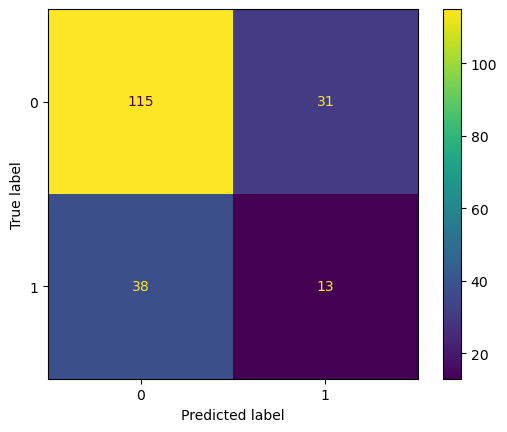

Accuracy: 0.649746192893401
Specificity: 0.7876712328767124
Precision: 0.29545454545454547
Sensitivity 0.2549019607843137
Negative Predictive Value: 0.7516339869281046
F1-score: 0.27368421052631586


In [25]:
# Fitting the model
model = tree.DecisionTreeClassifier()
model = model.fit(X_train,y_train)

yp_train = model.predict(X_train)
yp_test = model.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train,yp_train)

print("------TEST------")
confusion_plot(y_test,yp_test)

As we can see, as expected, our model is biased towards the majority class. Our decision tree with our training data likes to classify non podium finishers over true podium finishers, as expected. With our test data, we can see about a 65% accuracy and a really poor F-1 score of around 23%. The precision and sensitivity are really poor for this model, making this un-tuned decision tree not too great of a predictive model. Before we visualize our decision tree, let's see if we can tune it.

### Hyperparameter Tuning

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

val_results=[]
train_results=[]

for num_layer in range(1,20):
    model = tree.DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(X_train,y_train)

    yp_train=model.predict(X_train)
    yp_val=model.predict(X_val)

    # print(y_pred.shape)
    val_results.append([num_layer,accuracy_score(y_val, yp_val),f1_score(y_val, yp_val),precision_score(y_val, yp_val,zero_division=0),recall_score(y_val,yp_val)])
    train_results.append([num_layer, accuracy_score(y_train, yp_train), f1_score(y_train, yp_train),precision_score(y_train, yp_train,zero_division=0),recall_score(y_val,yp_val)])

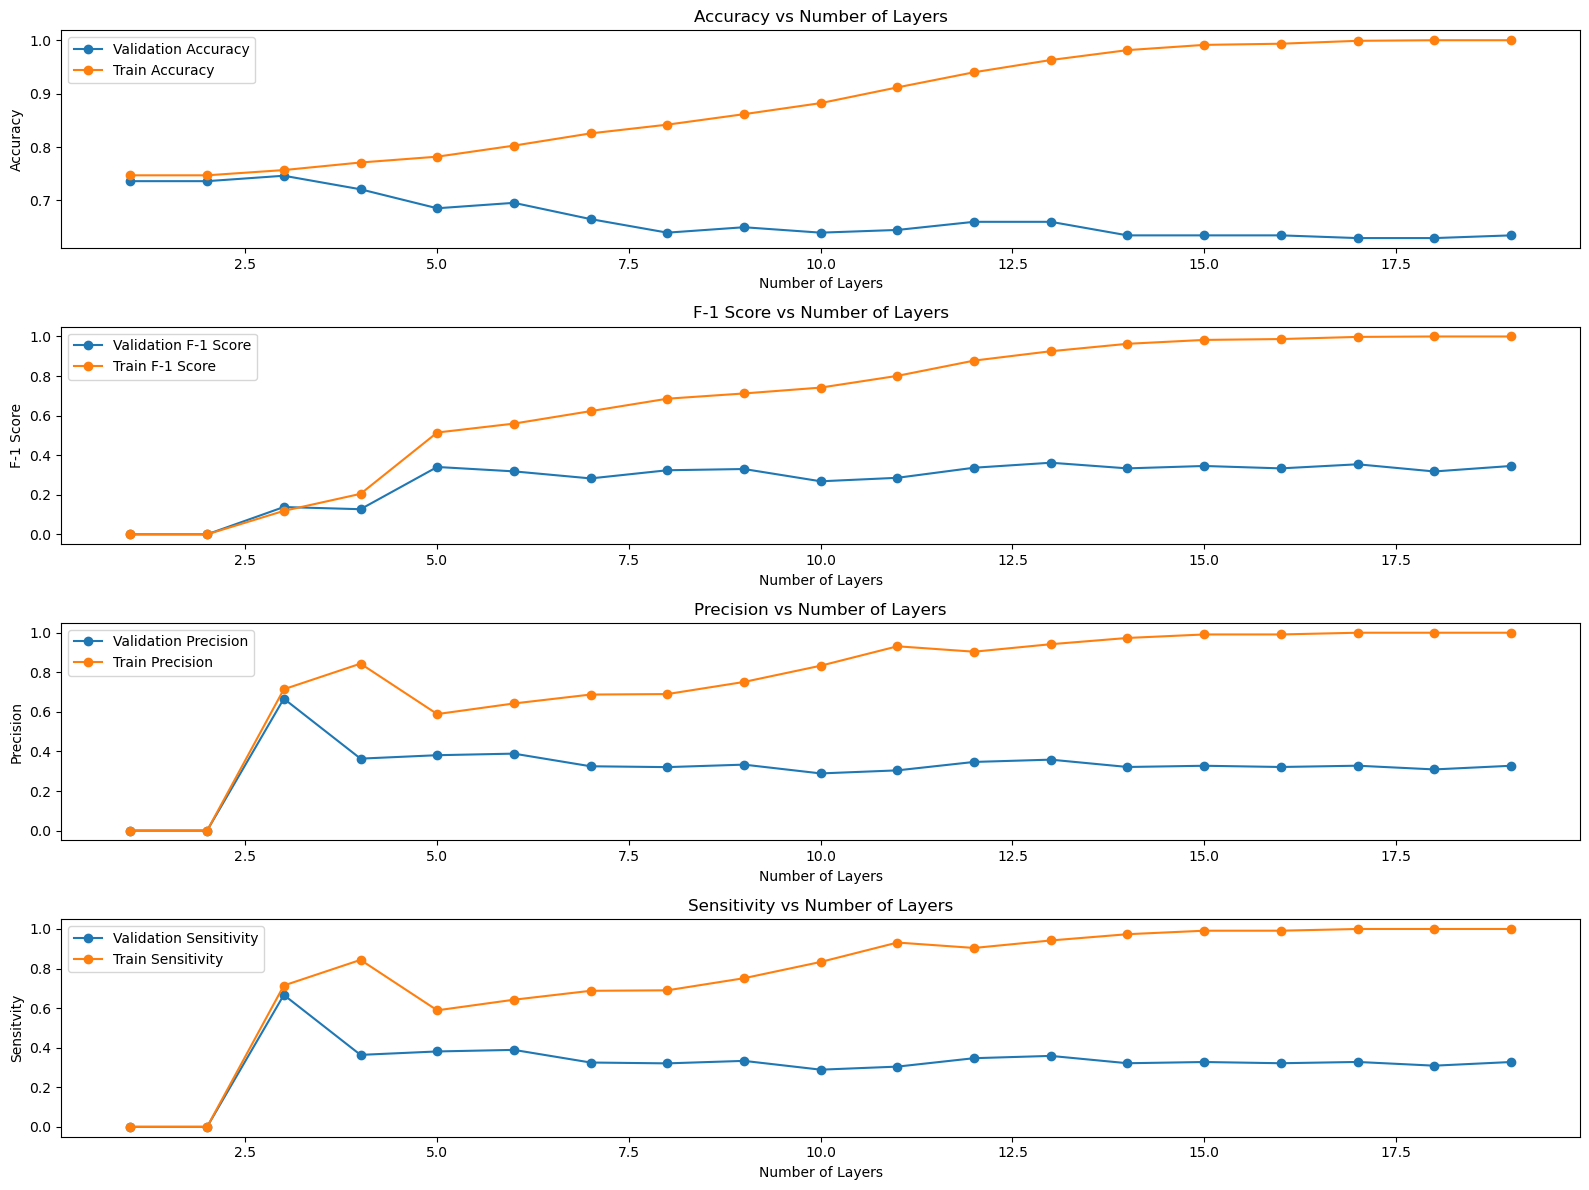

In [27]:
val_results = np.array(val_results)
train_results = np.array(train_results)

num_layers = val_results[:, 0]
val_accuracy = val_results[:, 1]
val_f1 = val_results[:, 2]
val_precision = val_results[:, 3]
val_sensitivity = val_results[:, 4]

train_accuracy = train_results[:, 1]
train_f1 = train_results[:, 2]
train_precision = train_results[:, 3]
train_sensitivity = train_results[:, 4]

plt.figure(figsize=(16, 12))

# Accuracy Plot
plt.subplot(4, 1, 1)
plt.plot(num_layers, val_accuracy, label='Validation Accuracy', marker='o')
plt.plot(num_layers, train_accuracy, label='Train Accuracy', marker='o')
plt.title('Accuracy vs Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
plt.legend()

# F-1 Score Plot
plt.subplot(4, 1, 2)
plt.plot(num_layers, val_f1, label='Validation F-1 Score', marker='o')
plt.plot(num_layers, train_f1, label='Train F-1 Score', marker='o')
plt.title('F-1 Score vs Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('F-1 Score')
plt.legend()

# Precision Plot
plt.subplot(4, 1, 3)
plt.plot(num_layers, val_precision, label='Validation Precision', marker='o')
plt.plot(num_layers, train_precision, label='Train Precision', marker='o')
plt.title('Precision vs Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Precision')
plt.legend()

# Sensitivity Plot
plt.subplot(4, 1, 4)
plt.plot(num_layers, val_precision, label='Validation Sensitivity', marker='o')
plt.plot(num_layers, train_precision, label='Train Sensitivity', marker='o')
plt.title('Sensitivity vs Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Sensitvity')
plt.legend()

plt.tight_layout()
plt.show()

There are a few judgement calls we have to make here. One of the first observations we can make is that our precision, the ability of our classifier to correctly predict podium finishers, is much better than our random classifier for any max depth after 2 layers. Our primary goal of such a decision tree should be to maximize precision, since in a betting market, we want to maximize the probability that we correctly select a podium finisher.

In terms of sensitivity, we also see a drop off after 3 layers. Sensitivity conveys to us our ability to pick podium finishers while taking into account horses we incorrectly said we would not finish on the podium. If we are able to maximize sensitivity, we are able to make sure we are not missing out on any betting opportunities. However, being right in a betting market is more important than missing out on opportunities, so we should still maximize precision

We can also look at trying to get a balance between accuracy and F-1 score. F-1 score peaks at 5 layers and accuracy falls off immediately after 1 layer. F-1 score would be a metric worth optimizing if we wanted a model that balances maximizing betting opportunities and being correct in our picks, but again, we really just want to maximize correctly picking podium finishers, so precision should be our main concern. Thus, we are going to pick 3 as our max depth.

Let's go ahead and fit our model with our tuned hyperparameter, measure its effectiveness, and finally visualize the tree.

------TRAINING------


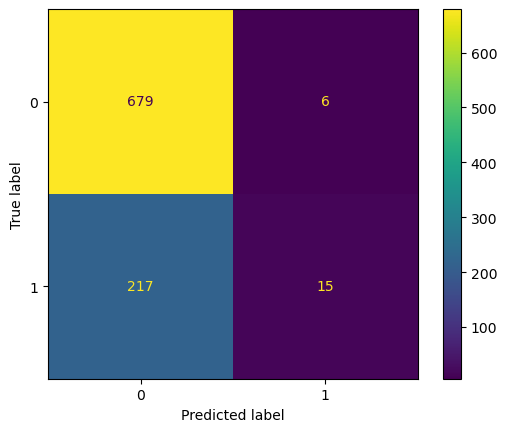

Accuracy: 0.7568157033805889
Specificity: 0.9912408759124087
Precision: 0.7142857142857143
Sensitivity 0.06465517241379311
Negative Predictive Value: 0.7578125
F1-score: 0.11857707509881424
------TEST------


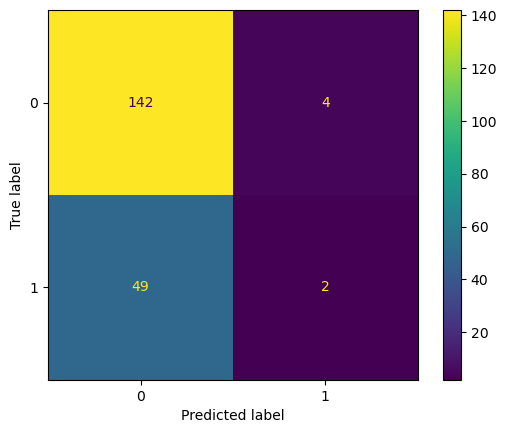

Accuracy: 0.7309644670050761
Specificity: 0.9726027397260274
Precision: 0.3333333333333333
Sensitivity 0.0392156862745098
Negative Predictive Value: 0.743455497382199
F1-score: 0.07017543859649122


In [28]:
model = tree.DecisionTreeClassifier(max_depth=3)
model = model.fit(X_train,y_train)

yp_train=model.predict(X_train)
yp_test=model.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train,yp_train)
print("------TEST------")
confusion_plot(y_test,yp_test)

With this decision tree. There are a few things of which to take note. We are maximizing precision, so our F-1 score is BAD. Our Accuracy is fairly solid, showing that we are able to weed out a lot of the non podium finishers fairly well. We are missing out on some betting opportunities by having a low sensitivity, but doing such ensures we are not making a lot of bets on podium finishers that are not. Overall, this decision tree would be ineffective predicition model in practice as the precision really could be tuned beyond 0.33, which we will do in following sections. We will go ahead and visualize our decision tree. While our decision tree will not be our final model, it DOES serve as fantastic visualization for the decision process of picking podium finishers.

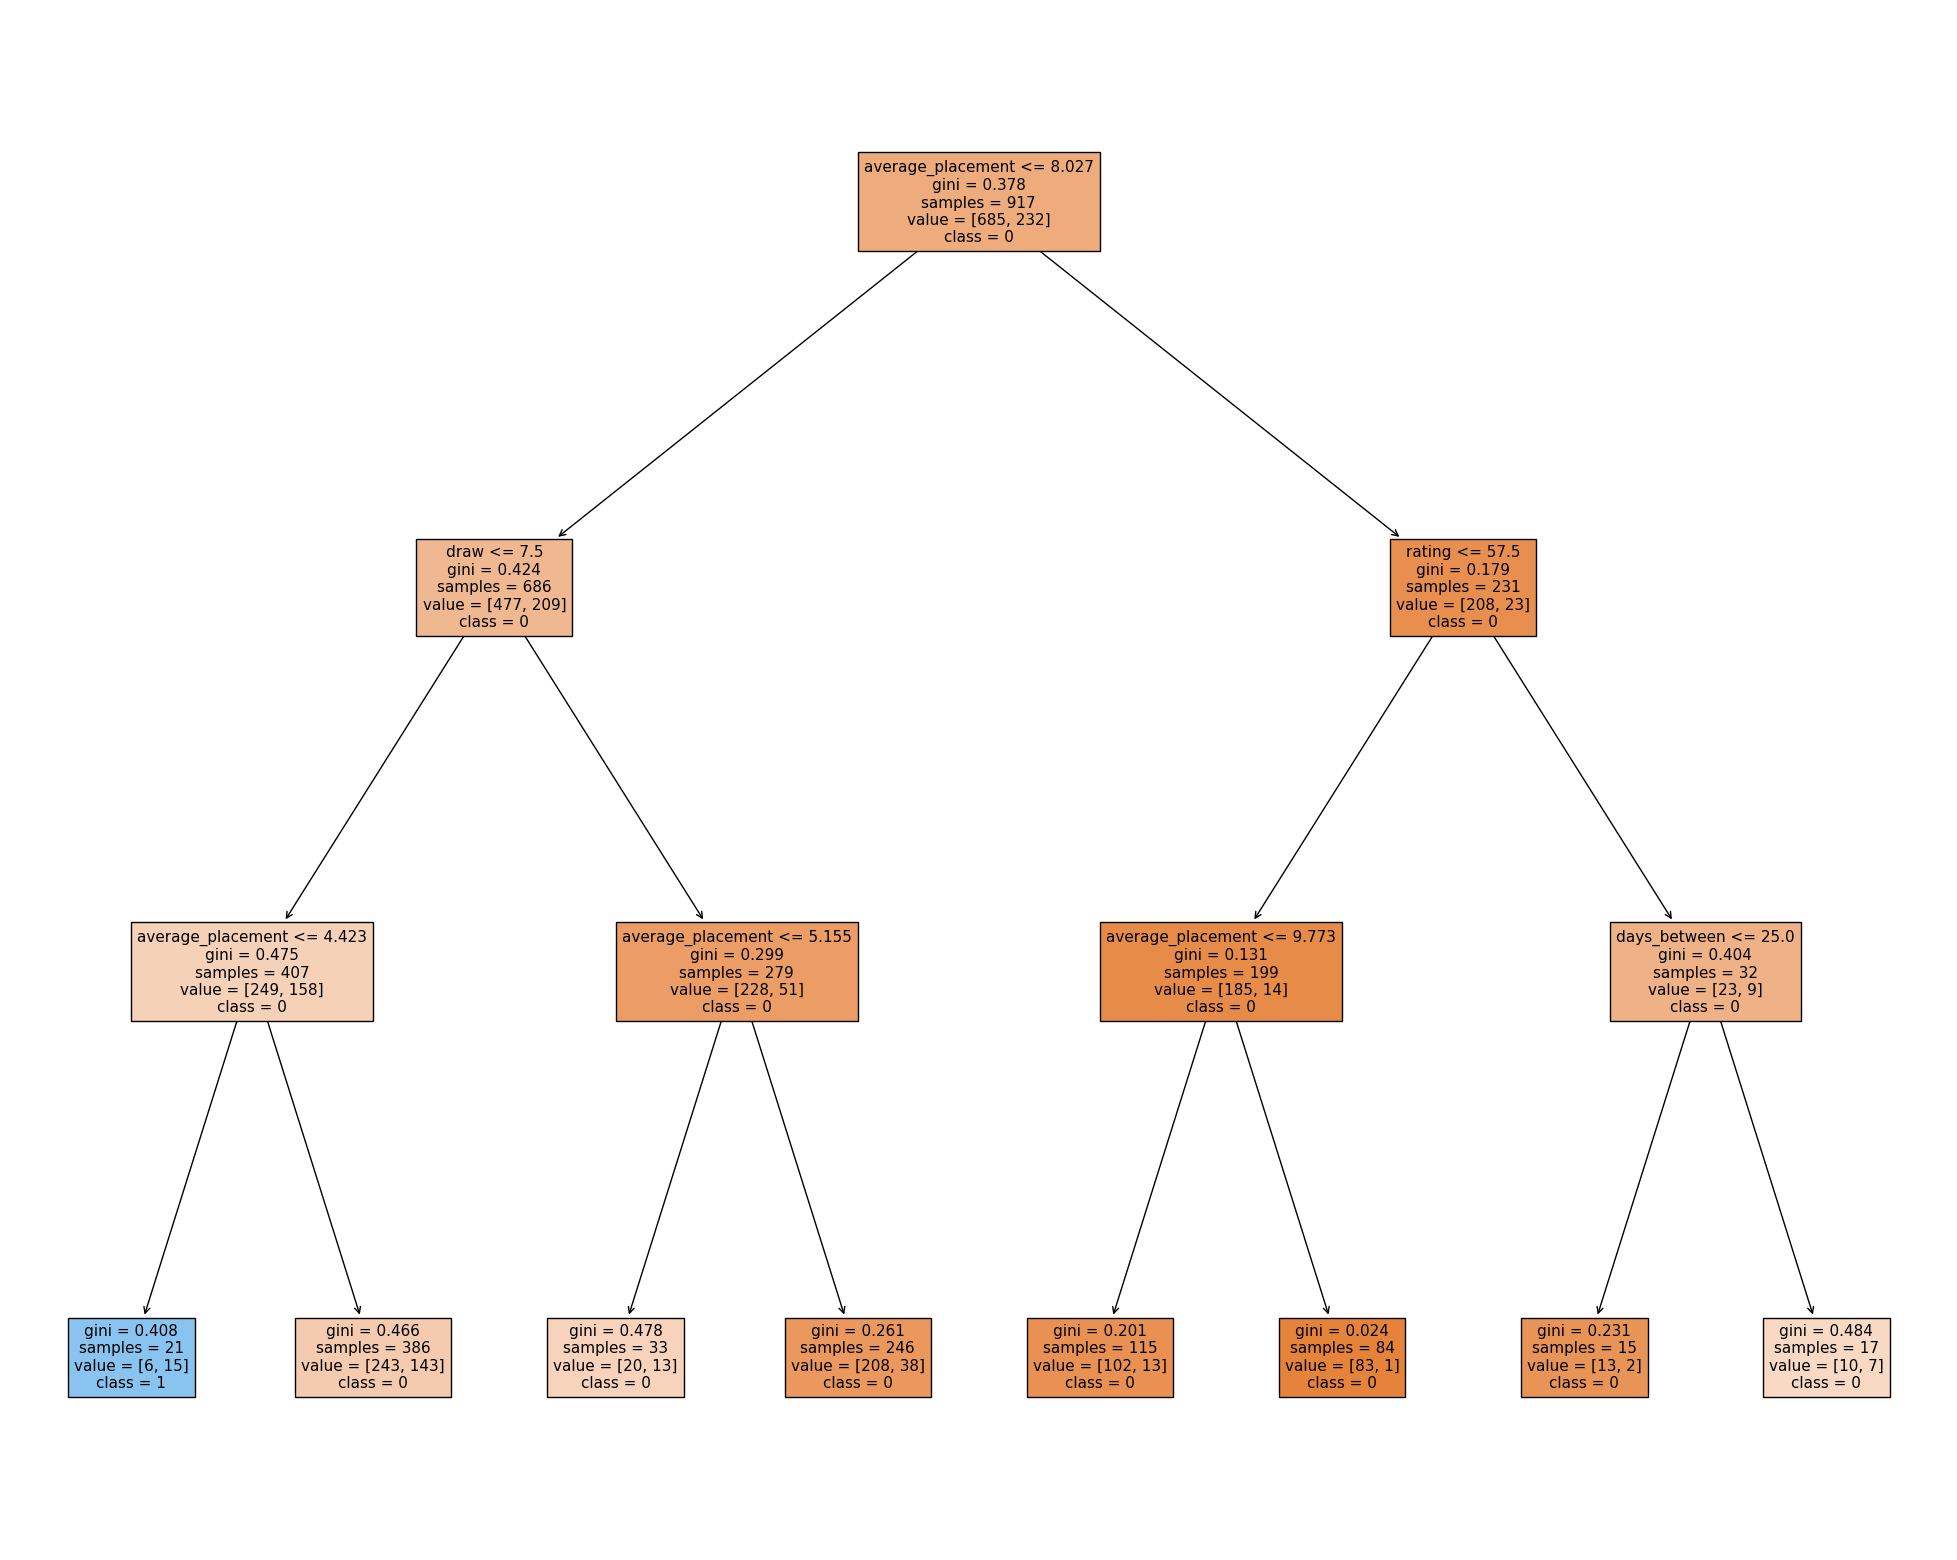

In [29]:
class_names = y.unique()

feature_names = [str(col) for col in X.columns]

plt.figure(figsize=(25,20))
tree.plot_tree(model, 
                feature_names=feature_names,  
                class_names=[str(class_name) for class_name in class_names],
                filled=True)
plt.show()

# Random Forest
We will begin by first fitting an untuned random forest model to our training data and then measuring its classification effectiveness before tuning hyperparameters. First, let's make sure there are no NaN values in our feature set as our Random Forest Classifier will not be able to handle them.

------TRAINING------


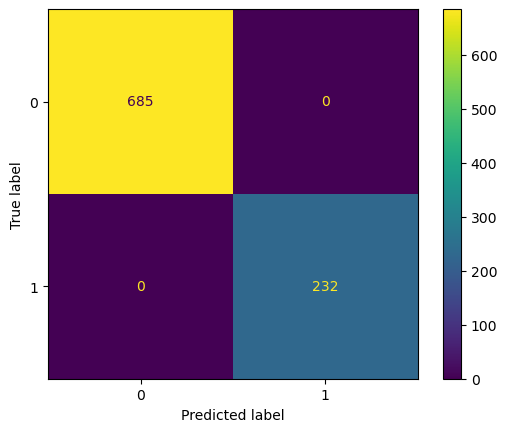

Accuracy: 1.0
Specificity: 1.0
Precision: 1.0
Sensitivity 1.0
Negative Predictive Value: 1.0
F1-score: 1.0
------TEST------


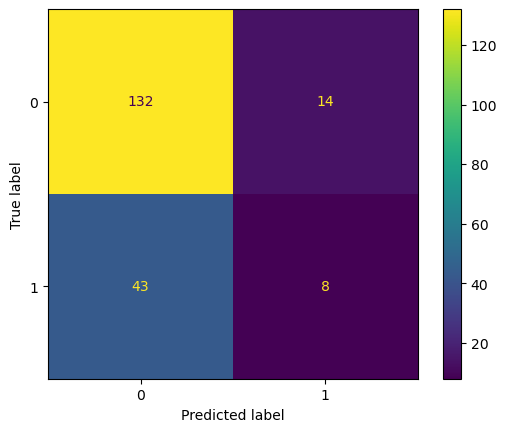

Accuracy: 0.7106598984771574
Specificity: 0.9041095890410958
Precision: 0.36363636363636365
Sensitivity 0.1568627450980392
Negative Predictive Value: 0.7542857142857143
F1-score: 0.21917808219178084


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=100)
rf_classifier = rf_classifier.fit(X_train,y_train)

yp_train = rf_classifier.predict(X_train)
yp_test = rf_classifier.predict(X_test)

yp_train = rf_classifier.predict(X_train)
yp_test = rf_classifier.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train,yp_train)
print("------TEST------")
confusion_plot(y_test,yp_test)

We can already see that an un-tuned random forest is giving us higher precision than any of our previous decision trees (with a score of 0.36), and most importantly, our random classifier (by around 10%). Still, we would like to tune this precision to be much higher. Below, we will perform a grid search with a variety of parameters utilized by the random forest algorithim and then a fit a tuned random forest.

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_classifier = RandomForestClassifier(random_state=100)

# Define the hyperparameters and their distributions
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Use RandomizedSearchCV to find the best hyperparameters based on precision
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, n_iter=50, scoring='precision', cv=5, random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = random_search.best_params_
best_rf_classifier = random_search.best_estimator_

yp_train = best_rf_classifier.predict(X_train)
yp_test = best_rf_classifier.predict(X_test)

yp_train = best_rf_classifier.predict(X_train)
yp_test = best_rf_classifier.predict(X_test)


------TRAINING------


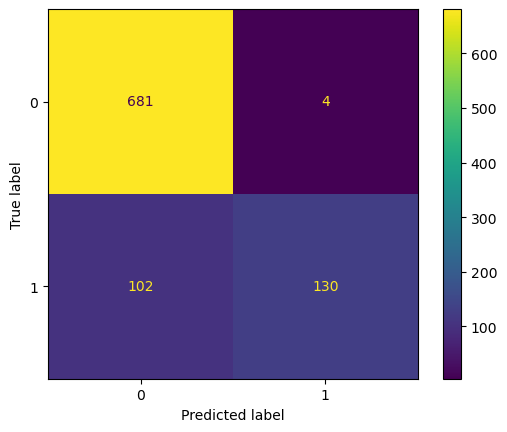

Accuracy: 0.8844056706652127
Specificity: 0.9941605839416059
Precision: 0.9701492537313433
Sensitivity 0.5603448275862069
Negative Predictive Value: 0.8697318007662835
F1-score: 0.7103825136612022
------TEST------


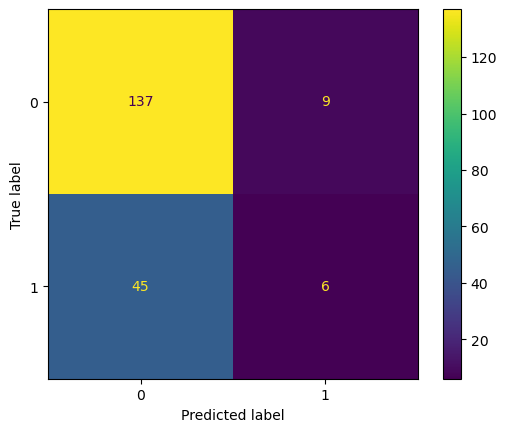

Accuracy: 0.7258883248730964
Specificity: 0.9383561643835616
Precision: 0.4
Sensitivity 0.11764705882352941
Negative Predictive Value: 0.7527472527472527
F1-score: 0.1818181818181818


In [32]:
print("------TRAINING------")
confusion_plot(y_train,yp_train)
print("------TEST------")
confusion_plot(y_test,yp_test)

Now, we can see that our Random Forest is giving us the highest precision we have seen on our test data yet with a precision of 40%, about 15% higher than a random classifer. Certainly, now, we are starting to get a predictive model that is able to give us betting winners at a more successful rate. Still, in a perfect world, we would have a model that when it tells us a horse is going to finish on the podium, it be would be right AT LEAST more than half of the time. Now, having a precision score of 40% is not useless (which I will touch on later), but, ideally, we could still improve on it.

## ADABoost
Now we will try boosting, specifically adaptive boosting through sklearn's ADABoostClassifier function. Let's fit an initial model before tuning it.

------TRAINING------


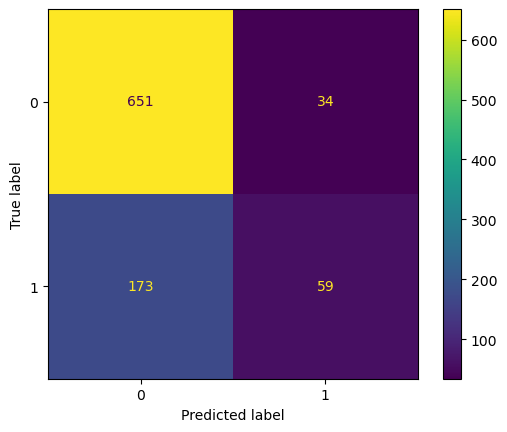

Accuracy: 0.7742639040348964
Specificity: 0.9503649635036496
Precision: 0.6344086021505376
Sensitivity 0.2543103448275862
Negative Predictive Value: 0.7900485436893204
F1-score: 0.363076923076923
------TEST------


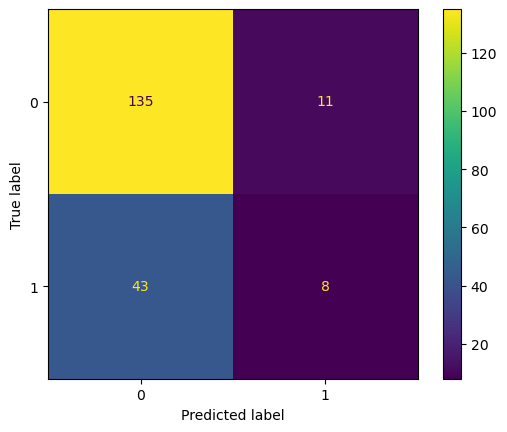

Accuracy: 0.7258883248730964
Specificity: 0.9246575342465754
Precision: 0.42105263157894735
Sensitivity 0.1568627450980392
Negative Predictive Value: 0.7584269662921348
F1-score: 0.22857142857142856


In [33]:
from sklearn.ensemble import AdaBoostClassifier

ada_classifier = AdaBoostClassifier(random_state=100)
ada_classifier = ada_classifier.fit(X_train,y_train)

yp_train = ada_classifier.predict(X_train)
yp_test = ada_classifier.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train,yp_train)
print("------TEST------")
confusion_plot(y_test,yp_test)

ALREADY, through an untuned adaboost model, we have a precision score of about 42% which is higher than any tuned model we have created so far. Now let's see what happens when we tune the model.

In [34]:
from sklearn.model_selection import GridSearchCV
ada_classifier = AdaBoostClassifier(random_state=100)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Use GridSearchCV to find the best hyperparameters based on precision
grid_search = GridSearchCV(
    ada_classifier, param_grid, scoring='precision', cv=5, n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_ada_classifier = grid_search.best_estimator_

# Make predictions on the validation set using the best model
y_val_pred = best_ada_classifier.predict(X_val)

# Evaluate precision on the validation set
precision_val = precision_score(y_val, y_val_pred)
print(f"Best Parameters: {best_params}")
print(f"Precision on Validation Set: {precision_val}")


/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Precision on Validation Set: 0.6666666666666666


When testing our tuned model on our validation set, we get a precision of 66.7% which is fantastic! Let's test this model on our test set to see if generalizes well to another unseen data set.

------TRAINING------


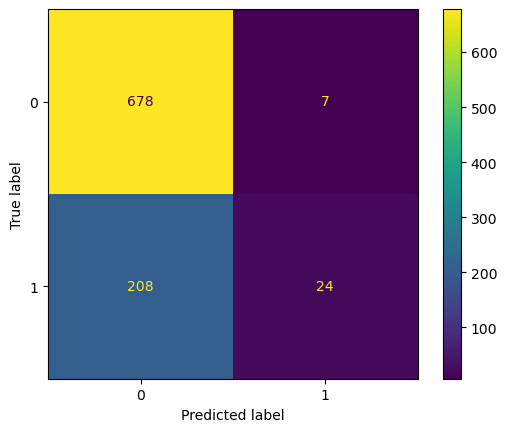

Accuracy: 0.7655398037077427
Specificity: 0.9897810218978103
Precision: 0.7741935483870968
Sensitivity 0.10344827586206896
Negative Predictive Value: 0.7652370203160271
F1-score: 0.18250950570342206
------TEST------


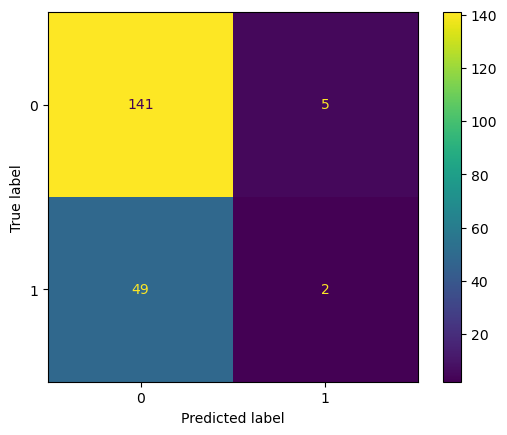

Accuracy: 0.7258883248730964
Specificity: 0.9657534246575342
Precision: 0.2857142857142857
Sensitivity 0.0392156862745098
Negative Predictive Value: 0.7421052631578947
F1-score: 0.06896551724137931


In [35]:
yp_test = best_ada_classifier.predict(X_test)
yp_train = best_ada_classifier.predict(X_train)

print("------TRAINING------")
confusion_plot(y_train,yp_train)
print("------TEST------")
confusion_plot(y_test,yp_test)

Uh oh. Unfortunately, while while our tuning process worked out really well with our validation dataset, it performed very poorly on our test set with a precision of around 28%. Such phenomena might be a sign we are overfitting our model to our training data. This overfitting can easily be a symptom of having an imbalanced dataset. Let's re-try this process, but this time, performing random oversampling in order to combat the imbalance of classes in our dataset.

In [36]:
from imblearn.over_sampling import SMOTE

# Assuming X_train, y_train are your training data
oversampler = SMOTE(sampling_strategy='auto', random_state=100)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)


------TRAINING------


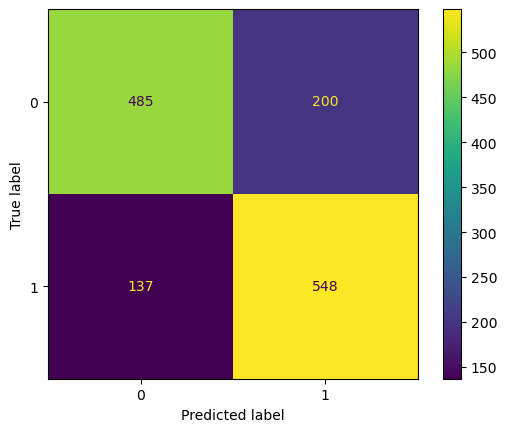

Accuracy: 0.754014598540146
Specificity: 0.708029197080292
Precision: 0.732620320855615
Sensitivity 0.8
Negative Predictive Value: 0.7797427652733119
F1-score: 0.7648290300069784
------TEST------


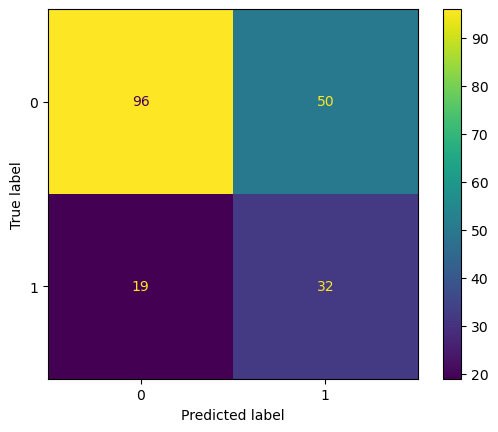

Accuracy: 0.649746192893401
Specificity: 0.6575342465753424
Precision: 0.3902439024390244
Sensitivity 0.6274509803921569
Negative Predictive Value: 0.8347826086956521
F1-score: 0.4812030075187971


In [75]:
yp_train = best_ada_classifier.predict(X_train_resampled)
yp_test = best_ada_classifier.predict(X_test)

yp_train = best_ada_classifier.predict(X_train_resampled)
yp_test = best_ada_classifier.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train_resampled,yp_train)

print("------TEST------")
confusion_plot(y_test,yp_test)

With oversampling, we do get a massive 10% boost in precision to our tuned AdaBoost model. Still, though, this precision is not as high as our original untuned AdaBoost model which has a precision of around 42%. We are going to try and continue fitting a more precise model.

# XgBoost
We will now attempt some gradient boosting.

------TRAINING------


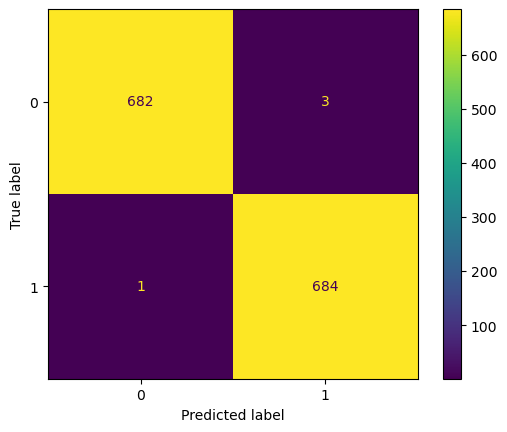

Accuracy: 0.997080291970803
Specificity: 0.9956204379562044
Precision: 0.9956331877729258
Sensitivity 0.9985401459854014
Negative Predictive Value: 0.9985358711566618
F1-score: 0.9970845481049562
------TEST------


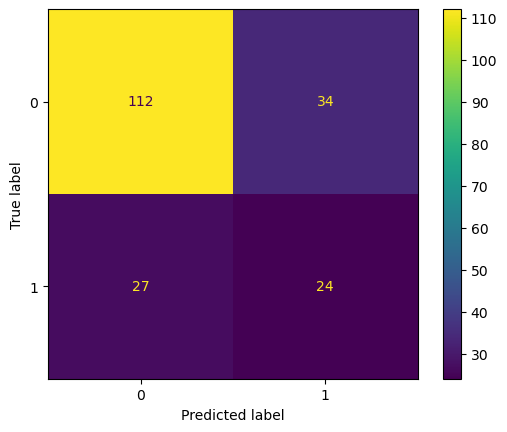

Accuracy: 0.6903553299492385
Specificity: 0.7671232876712328
Precision: 0.41379310344827586
Sensitivity 0.47058823529411764
Negative Predictive Value: 0.8057553956834532
F1-score: 0.4403669724770642


In [76]:
from xgboost import XGBClassifier

# Define the XGBoost model
xgb_model = XGBClassifier()

# Train the model on the resampled data
xgb = xgb_model.fit(X_train_resampled, y_train_resampled)

yp_train = xgb.predict(X_train_resampled)
yp_test = xgb.predict(X_test)

yp_train = xgb.predict(X_train_resampled)
yp_test = xgb.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train_resampled,yp_train)
print("------TEST------")
confusion_plot(y_test,yp_test)

Once again, we have fairly solid results here with a precision of around 41%, but I still want to see if we can get a higher precision.

# Combining Classifier Methods
Under this section, we will be combining a variety of decision tree/ensemble methods in order to try and improve precision.

## "Voting" with AdaBoost and Random Forest
We will be using an adaboost and random forest model and then using a "voting" process to optimize how we are assigning our classes.

------TRAINING------


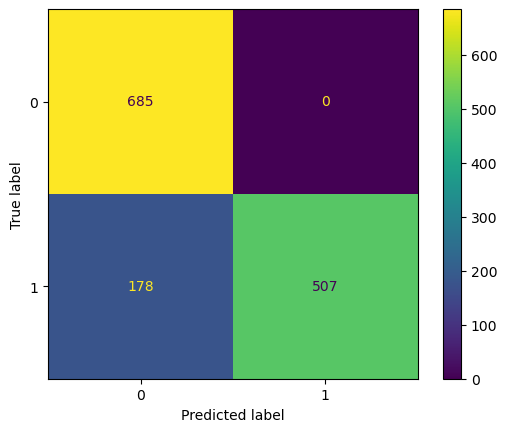

Accuracy: 0.8700729927007299
Specificity: 1.0
Precision: 1.0
Sensitivity 0.7401459854014598
Negative Predictive Value: 0.7937427578215527
F1-score: 0.8506711409395973
------TEST------


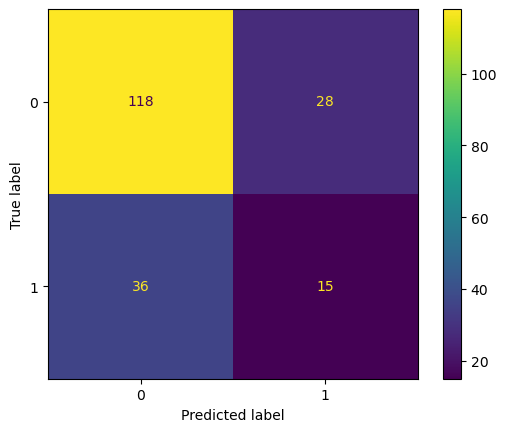

Accuracy: 0.6751269035532995
Specificity: 0.8082191780821918
Precision: 0.3488372093023256
Sensitivity 0.29411764705882354
Negative Predictive Value: 0.7662337662337663
F1-score: 0.3191489361702128


In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier()

# Define different base classifiers
base_classifier_adaboost = AdaBoostClassifier(base_classifier, n_estimators=50)
base_classifier_random_forest = RandomForestClassifier(n_estimators=50)

# Create an ensemble with different base classifiers
ensemble_model = VotingClassifier(
    estimators=[('adaboost', base_classifier_adaboost), ('random_forest', base_classifier_random_forest)],
    voting='soft'  # 'soft' for probability voting
)

# Train the ensemble model
ensemble_classifier = ensemble_model.fit(X_train, y_train)
yp_train = ensemble_classifier.predict(X_train_resampled)
yp_test = ensemble_classifier.predict(X_test)

yp_train = ensemble_classifier.predict(X_train_resampled)
yp_test = ensemble_classifier.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train_resampled,yp_train)

print("------TEST------")
confusion_plot(y_test,yp_test)

With this method, we get a precision around 35% which is still too low for our liking.

## Tuning the Base Classifier in an AdaBoost Classifier
We will now tune the base classifier parameters along with an AdaBoost classifier's parameters. For our base classifier, we will use a standard decision tree.

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the base estimator
base_estimator = DecisionTreeClassifier()

# Create the AdaBoost model
adaboost_model = AdaBoostClassifier(base_estimator=base_estimator, random_state=100)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Perform grid search
grid_search = GridSearchCV(adaboost_model, param_grid, scoring='precision', cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best model
best_adaboost_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)


/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

Best Parameters: {'algorithm': 'SAMME', 'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'learning_rate': 0.01, 'n_estimators': 100}


/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


It should be noted that this tuning process was fairly computationally expensive and took about 5 minutes to run.

------TRAINING------


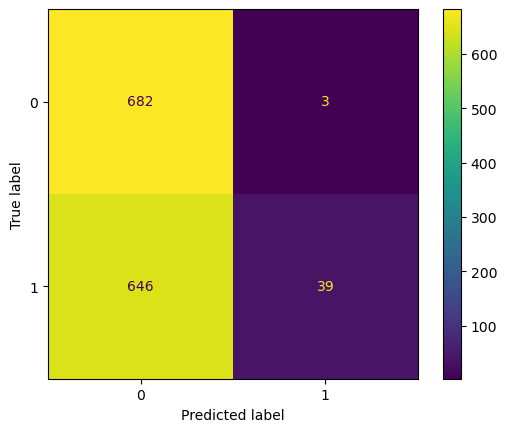

Accuracy: 0.5262773722627737
Specificity: 0.9956204379562044
Precision: 0.9285714285714286
Sensitivity 0.05693430656934306
Negative Predictive Value: 0.5135542168674698
F1-score: 0.10729023383768913
------TEST------


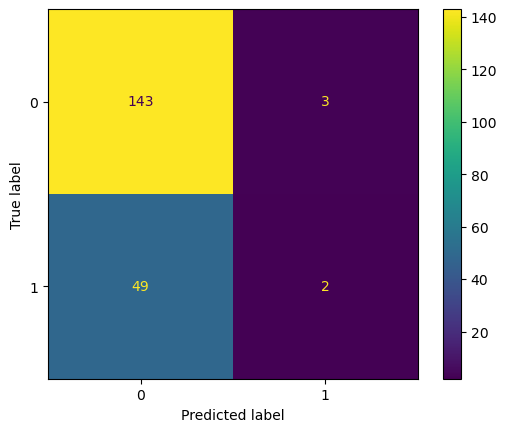

Accuracy: 0.7360406091370558
Specificity: 0.9794520547945206
Precision: 0.4
Sensitivity 0.0392156862745098
Negative Predictive Value: 0.7447916666666666
F1-score: 0.07142857142857142


In [67]:
yp_train = best_adaboost_model.predict(X_train)
yp_test = best_adaboost_model.predict(X_test)

yp_train = best_adaboost_model.predict(X_train)
yp_test = best_adaboost_model.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train_resampled,yp_train)

print("------TEST------")
confusion_plot(y_test,yp_test)

We can see that this method gave us a precision of 0.4 which STILL is too low for our liking. We continue onwards!

## Using a Random Forest as the Base Classifier for an AdaBoost Classifier
Now we are going to really turn up the jets and start combining some powerful classifiers. We are going to use a random forest as the base estimator for our AdaBoost model now.

/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


------TRAINING------


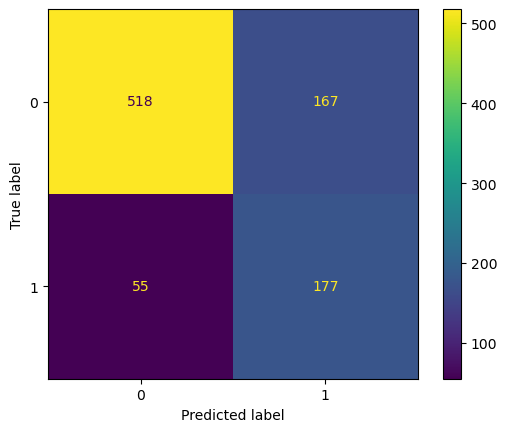

Accuracy: 0.7579062159214831
Specificity: 0.7562043795620438
Precision: 0.5145348837209303
Sensitivity 0.7629310344827587
Negative Predictive Value: 0.9040139616055847
F1-score: 0.6145833333333334
------TEST------


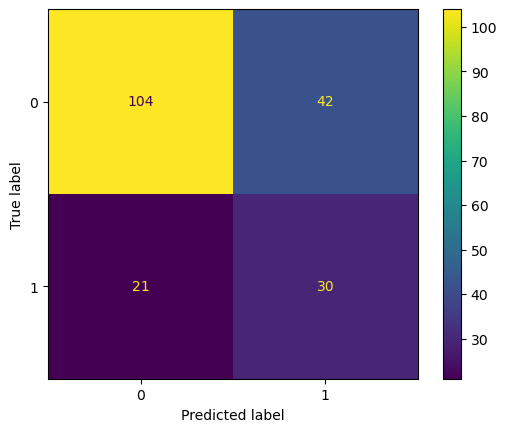

Accuracy: 0.6802030456852792
Specificity: 0.7123287671232876
Precision: 0.4166666666666667
Sensitivity 0.5882352941176471
Negative Predictive Value: 0.832
F1-score: 0.48780487804878053


In [70]:
base_rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# Create the AdaBoost model with Random Forest as the base estimator
adaboost_rf_model = AdaBoostClassifier(base_estimator=base_rf, n_estimators=100, learning_rate=0.1, random_state=100)



# Fit the model on the training data
ada_rf = adaboost_rf_model.fit(X_train, y_train)

yp_train = ada_rf.predict(X_train)
yp_test = ada_rf.predict(X_test)

yp_train = ada_rf.predict(X_train)
yp_test = ada_rf.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train,yp_train)

print("------TEST------")
confusion_plot(y_test,yp_test)

We now get a precision slightly under 42% which is right around where our orginal AdaBoost model is.

# Tuning an AdaBoost Classifier with a Random Forest as the Base Estimator
Now we will tune the parameters of both our AdaBoost classifier and the random forest we are using as our base estimator. This process is going to be extremely computationally expensive.

In [71]:
adaboost_rf_model = AdaBoostClassifier(base_estimator=base_rf, random_state=42)

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'base_estimator__n_estimators': [50, 100, 150],
    'base_estimator__max_depth': [3, 5, 7],
}

# Perform grid search
grid_search = GridSearchCV(adaboost_rf_model, param_grid, scoring='precision', cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best model
best_adaboost_rf_model = grid_search.best_estimator_

/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed 

This tuning process took **40 MINUTES** to run. Up to this point in my data science career, this is the longest I have ever had a coding cell block take to execute.

------TRAINING------


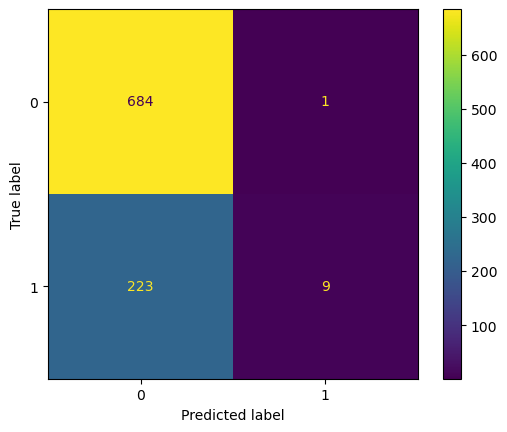

Accuracy: 0.7557251908396947
Specificity: 0.9985401459854014
Precision: 0.9
Sensitivity 0.03879310344827586
Negative Predictive Value: 0.7541345093715546
F1-score: 0.07438016528925619
------TEST------


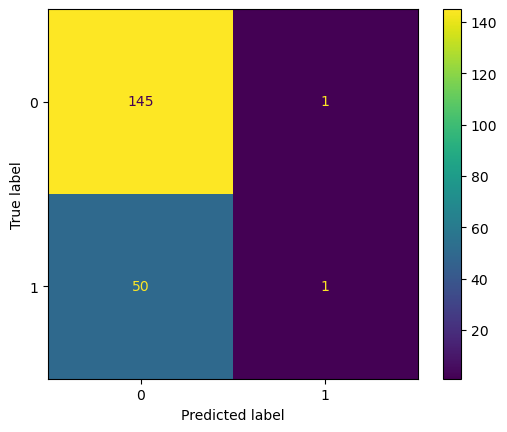

Accuracy: 0.7411167512690355
Specificity: 0.9931506849315068
Precision: 0.5
Sensitivity 0.0196078431372549
Negative Predictive Value: 0.7435897435897436
F1-score: 0.03773584905660377


In [74]:
yp_train = best_adaboost_rf_model.predict(X_train)
yp_test = best_adaboost_rf_model.predict(X_test)

yp_train = best_adaboost_rf_model.predict(X_train)
yp_test = best_adaboost_rf_model.predict(X_test)

print("------TRAINING------")
confusion_plot(y_train,yp_train)

print("------TEST------")
confusion_plot(y_test,yp_test)

FINALLY, we got a model with a precision higher than our 42% mark. This classifier had a precision of a whopping 50% which is absolutely amazing compared to any of our methods. Now, granted, our sensitivity is 1%, meaning we are missing out on A LOT of betting opportunities, but AGAIN, for the sake of this project, we are only concerned with being right in our bets.

# Final Results and Conclusion
Our final model, our *AdaBoost Classifier with a Random Forest Base Estimator*, was found to be our "best" model during this analysis. To re-iterate, the goal of this analysis was to develop a decision tree-based classifier model that is able to maximize precision as much as possible relative to a random classifier (which, on average, will give us precision of 25%). The reasoning for wanting to maximize precision over any of the other models is that precision tells us out of all the horse podium finishers we are predicting, we are predicting X percentage correct. In the betting world, being right is what makes you money. Measures like accuracy and negative predictive value, which help tell us how well our model is predicting horses that do NOT finish on the podium, are not helpful to us in a betting scenario. With a measure like sensitivity (recall), we are quantifying out of all the possible podium finishers, we are succesfully predicting X percentage of the total podium finisher pool. This measure is not totally unhelpful as it tells us the extent to which we are maximizing potential betting opportunities, but for the sake of this analysis, we care more about being right than maximizing potential betting opportunities, hence precision was our measure of interest for evaluating all of our models.

With our final model, we are able to get a precision of around 42%, about 17% higher than a random classifier. On the surface, this improvement might not seem like a lot, but it actually is quite meaningful. First of all, if you have a model with a super high precision score of anwyhere above around 80%, you might want to consider moving out to Hong Kong and picking up horse handicapping as a full-time job. Having such precision in picking horse podium finishers is something that many handicappers have committed their entire practice towards. What I am trying to say is that getting a super precision score with a model would be HARD. It is definitely possible, but more feature sets and advanced algorithims are likely needed. Secondly, 42% precision is NOT bad. In fact, it is more than enough to gain an edge if one were to use this model as a part of a more advanced betting system.

If we are able to fully confirm over more unseen data that our precision truly is 50%, we know that any time our model tells us that a horse is going to finish on the podium (for the exact same race scenario in which we built our model), then 50% of the time, we are going to be right. Knowing probabilities of outcomes is one of the first steps to developing a more advanced betting system. 

If we are given odds of anything 3:2 or better (+150 in American Odds) on a horse finishing on the podium and our model tells us the horse is going to finish on the podium, we can place a bet on the horse finishing on the podium and we will be placing what is known as a Positive Expected Value (EV) bet.With odds of 3 to 2, there are implied odds of 40% that the horse finishes on the podium. If we know our model is right 50% of the time and we are getting paid out like this outcome only happens 40% of the time, **we have an edge**. If we place a $100 bet on our horse, applying ["betting math"](https://oddsjam.com/betting-education/positive-expected-value-betting), we can expect a 25% return over the long run on such an event. Meaning, if we were to place 1000 of these bets over the long run, we can expect a profit of $25. This phenomena is the crux of how one becomes a succesfull sports handicapper. 

Now, if we place A LOT of these positive EV bets, you can probably see how OVER THE LONG RUN, some serious profit could be made. Again, assuming we are confident about our model's precision, along with an appropriate bet sizing system (like the Kelly Criterion), this model could produce some succesful results. Before you go and try to use this model or replicate these results, there are some important caveats of which one should make note. For one, one would need to have one of there decision tree models for EVERY SINGLE RACE SCENARIO in order to make such a betting venture even worthwhile. This means having a model for races of every distance, class, track condition, race location, and course. This is an operation that would get computationally expensive really quickly, especially considering our most "succesful" model took 40 minutes to tune for just one race scenario. Also, due to the fact we maximized precision over recall, the amount of betting opportunities our model would give us would likely be very minimal, meaning for every 300-500 races, you are probably only going to get 10 podium horses MAX that your model spits out. Due to these reasons, this project is simply an exploration of some the preliminary work that would go into making a more advanced betting system.

To summarize, our model, in theory, could be used to be a succesful horse racing handicapper (succesful meaning that we mathematically will not lose over the long run), but it would not perform well in practice due to its simplicity. If we were able to develop decision trees for every race scenario, with even higher precision, then maybe using the model to bet on the horses would become worthwhile. For now, that is not the case. It is very assuring, however, to see that we were able to develop the early beginnings of a mathematically profitable horse racing betting system.